
## Imports + load data

In [1]:
import pandas as pd

df = pd.read_csv("amz_uk_price_prediction_dataset.csv")

print("Shape:", df.shape)
print("Columns:", list(df.columns))
df.head()


Shape: (2443651, 9)
Columns: ['uid', 'asin', 'title', 'stars', 'reviews', 'price', 'isBestSeller', 'boughtInLastMonth', 'category']


,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
0,1,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
1,2,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099,23.99,True,0,Hi-Fi Speakers
2,3,B09B8YWXDF,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
3,4,B09B8T5VGV,"Echo Dot with clock (5th generation, 2022 rele...",4.7,7205,31.99,False,0,Hi-Fi Speakers
4,5,B09WX6QD65,Introducing Echo Pop | Full sound compact Wi-F...,4.6,1881,17.99,False,0,Hi-Fi Speakers


In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Plot settings (optional)
sns.set(style="whitegrid")
pd.set_option("display.max_columns", None)

# ---- Load dataset (exact filename) ----
DATA_FILE = Path("amz_uk_price_prediction_dataset.csv")
assert DATA_FILE.exists(), f"CSV not found at {DATA_FILE.resolve()}"

df = pd.read_csv(DATA_FILE)
print("Shape:", df.shape)
print("Columns:", list(df.columns))
df.head()


Shape: (2443651, 9)
Columns: ['uid', 'asin', 'title', 'stars', 'reviews', 'price', 'isBestSeller', 'boughtInLastMonth', 'category']


,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
0,1,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
1,2,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099,23.99,True,0,Hi-Fi Speakers
2,3,B09B8YWXDF,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
3,4,B09B8T5VGV,"Echo Dot with clock (5th generation, 2022 rele...",4.7,7205,31.99,False,0,Hi-Fi Speakers
4,5,B09WX6QD65,Introducing Echo Pop | Full sound compact Wi-F...,4.6,1881,17.99,False,0,Hi-Fi Speakers


## Quick data check

In [3]:
df.info()
df.describe(include="all").T.head(15)
df.isna().sum().sort_values(ascending=False).head(10)
print("Duplicate rows:", df.duplicated().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2443651 entries, 0 to 2443650
Data columns (total 9 columns):
 #   Column             Dtype  
---  ------             -----  
 0   uid                int64  
 1   asin               object 
 2   title              object 
 3   stars              float64
 4   reviews            int64  
 5   price              float64
 6   isBestSeller       bool   
 7   boughtInLastMonth  int64  
 8   category           object 
dtypes: bool(1), float64(2), int64(3), object(3)
memory usage: 151.5+ MB
Duplicate rows: 0


## Light cleaning

In [4]:
# Make sure key columns exist (adjust if Kaggle columns differ)
expected = ["category", "price", "stars"]
print({c: (c in df.columns) for c in expected})

# Coerce numeric columns safely
for col in ["price", "stars"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Basic trims/normalization for category text
if "category" in df.columns and df["category"].dtype == "object":
    df["category"] = df["category"].astype(str).str.strip()

# Drop clearly useless full-NaN rows for our target columns
keep_cols = [c for c in ["category", "price", "stars"] if c in df.columns]
df = df.dropna(subset=keep_cols, how="all").copy()

df[keep_cols].head()


{'category': True, 'price': True, 'stars': True}


,category,price,stars
0,Hi-Fi Speakers,21.99,4.7
1,Hi-Fi Speakers,23.99,4.7
2,Hi-Fi Speakers,21.99,4.7
3,Hi-Fi Speakers,31.99,4.7
4,Hi-Fi Speakers,17.99,4.6


## *Categories* (frequency + visuals)

In [5]:
# Frequency table
cat_counts = df["category"].value_counts(dropna=False)
cat_counts.head(15)


category
Sports & Outdoors                         836265
Beauty                                     19312
Handmade Clothing, Shoes & Accessories     19229
Bath & Body                                19092
Birthday Gifts                             18978
Manicure & Pedicure Products               18940
Skin Care                                  18769
Make-up                                    18756
Hair Care                                  18735
Fragrances                                 18564
Handmade Gifts                             18295
Handmade Home Décor                        18146
Luggage and travel gear                    18142
Handmade Jewellery                         18044
Handmade Artwork                           17878
Name: count, dtype: int64

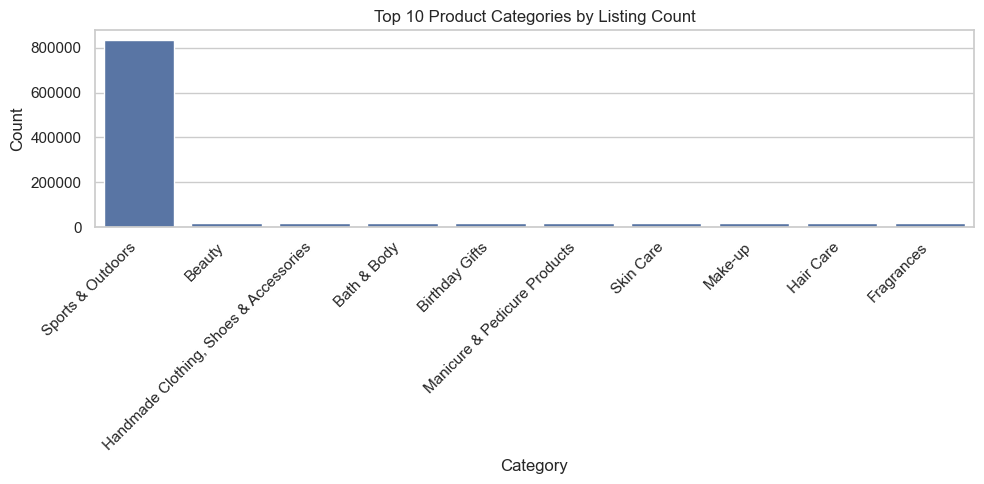

In [6]:
# Bar chart: Top 10 categories
top_n = 10
plt.figure(figsize=(10,5))
sns.barplot(x=cat_counts.head(top_n).index, y=cat_counts.head(top_n).values)
plt.title(f"Top {top_n} Product Categories by Listing Count")
plt.xlabel("Category")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


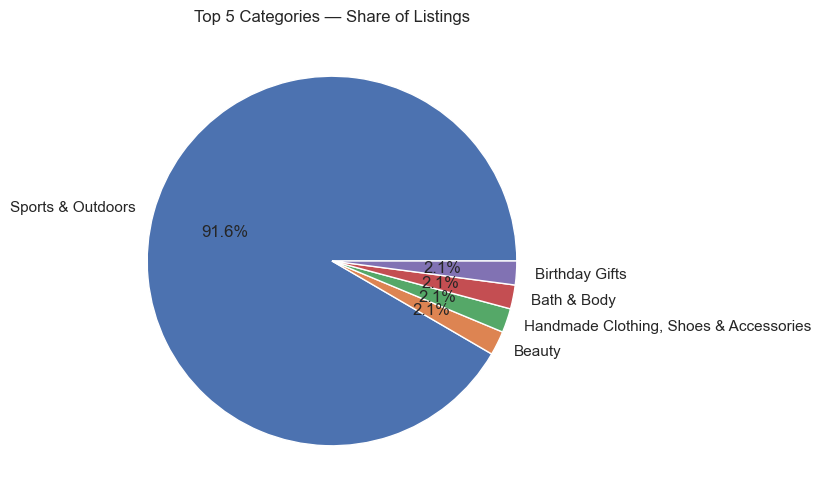

In [7]:
# Pie chart: Top 5 proportions
plt.figure(figsize=(6,6))
cat_counts.head(5).plot(kind="pie", autopct="%1.1f%%", ylabel="")
plt.title("Top 5 Categories — Share of Listings")
plt.show()


Insights: Product Categories

The dataset is heavily skewed towards the Sports & Outdoors category, which alone contributes over 830K listings (~92% of all products).

The remaining top categories (Beauty, Handmade Clothing & Accessories, Bath & Body, Birthday Gifts) each account for only about 2% of listings.

This indicates that Sports & Outdoors is a highly saturated market on Amazon UK, with significant competition for visibility and pricing.

In contrast, smaller categories like Beauty and Handmade products are relatively niche and may offer opportunities for businesses to target specialized audiences with less competition.

From a strategic standpoint, businesses may either:

Focus on differentiation to stand out in the crowded Sports & Outdoors space, or

Capitalize on niche categories where competition is lower but targeted demand still exists.

## **Pricing (central tendency, spread, visuals)**

In [8]:
price = df["price"].dropna()
summary = {
    "count": price.count(),
    "mean": price.mean(),
    "median": price.median(),
    "mode": price.mode().iloc[0] if not price.mode().empty else np.nan,
    "min": price.min(),
    "max": price.max(),
    "std": price.std(),
    "var": price.var(),
    "q1": price.quantile(0.25),
    "q3": price.quantile(0.75),
}
summary


{'count': np.int64(2443651),
 'mean': np.float64(89.24380943923663),
 'median': 19.09,
 'mode': np.float64(9.99),
 'min': 0.0,
 'max': 100000.0,
 'std': 345.60886175352226,
 'var': 119445.48532256528,
 'q1': np.float64(9.99),
 'q3': np.float64(45.99)}

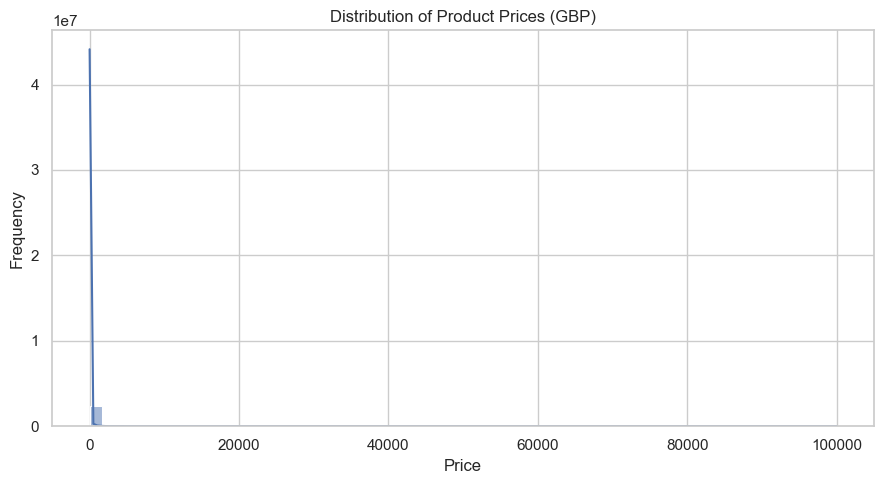

In [9]:
# Histogram (prices often skewed right)
plt.figure(figsize=(9,5))
sns.histplot(price, bins=60, kde=True)
plt.title("Distribution of Product Prices (GBP)")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


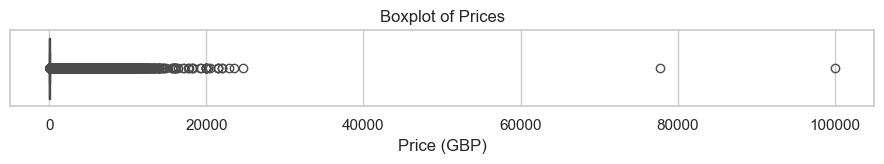

In [10]:
# Boxplot to visualize spread & outliers
plt.figure(figsize=(9,1.8))
sns.boxplot(x=price)
plt.title("Boxplot of Prices")
plt.xlabel("Price (GBP)")
plt.tight_layout()
plt.show()


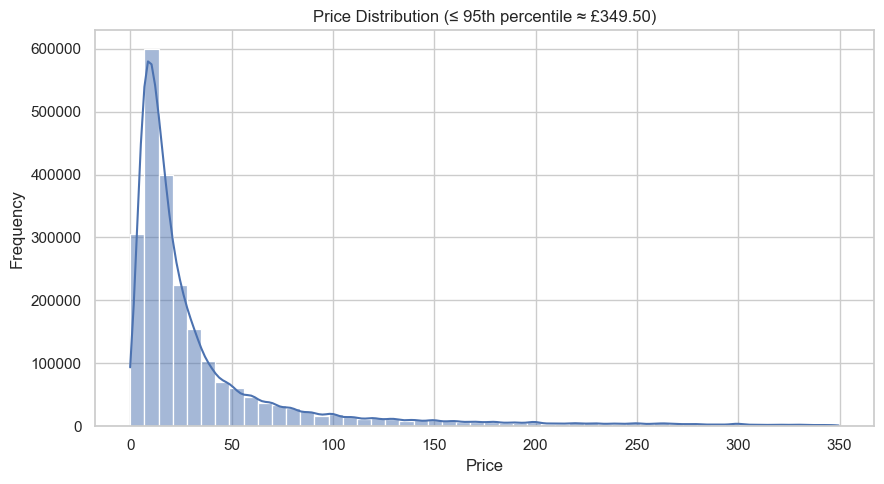

In [11]:
upper = price.quantile(0.95)
plt.figure(figsize=(9,5))
sns.histplot(price[price <= upper], bins=50, kde=True)
plt.title(f"Price Distribution (≤ 95th percentile ≈ £{upper:.2f})")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


The average product price is around £89, but the median is only ~£19, showing a heavily right-skewed distribution.

The mode (most frequent price point) is about £10, suggesting many products are positioned at low entry-level price bands.

Prices range from £0 to £100,000, though the vast majority of listings fall below £350 (95th percentile).

The boxplot confirms strong skewness with many extreme outliers — a small number of luxury or premium items inflate the maximum price.

For most customers, the affordable segment (under £50) is the core market, while high-ticket items represent specialized, niche demand.

From a business perspective:

Competing in the £10–£30 range may require strong differentiation due to crowding.

There is also opportunity for premium positioning (above £350), but only for brands that can justify higher value through quality, brand strength, or uniqueness.

## Ratings (tendency, spread, shape)

In [12]:
ratings = df["stars"].dropna()

rating_stats = {
    "count": ratings.count(),
    "mean": ratings.mean(),
    "median": ratings.median(),
    "mode": ratings.mode().iloc[0] if not ratings.mode().empty else np.nan,
    "std": ratings.std(),
    "var": ratings.var(),
    "q1": ratings.quantile(0.25),
    "q3": ratings.quantile(0.75),
    "skew": ratings.skew(),
    "kurtosis": ratings.kurt(),
}
rating_stats


{'count': np.int64(2443651),
 'mean': np.float64(2.152836472966065),
 'median': 0.0,
 'mode': np.float64(0.0),
 'std': 2.1948653785054697,
 'var': 4.81743402976196,
 'q1': np.float64(0.0),
 'q3': np.float64(4.4),
 'skew': np.float64(0.08120735761080985),
 'kurtosis': np.float64(-1.9260061280432985)}

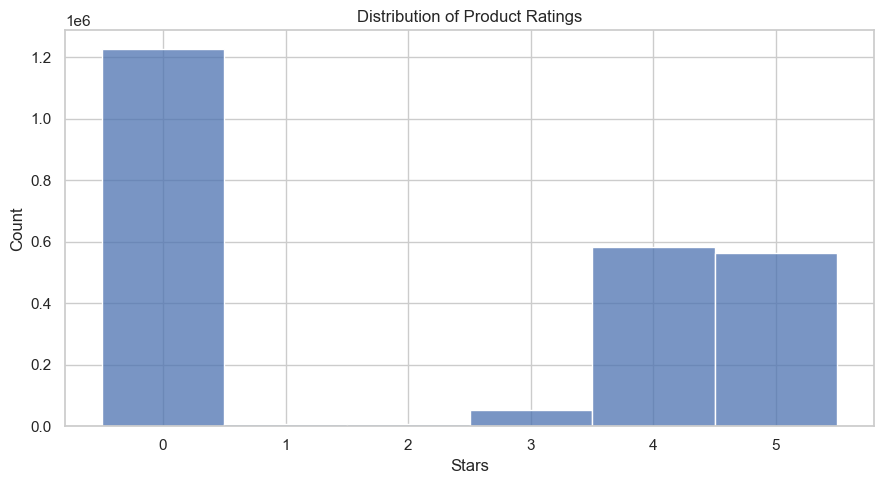

In [13]:
plt.figure(figsize=(9,5))
sns.histplot(ratings, bins=10, discrete=True)
plt.title("Distribution of Product Ratings")
plt.xlabel("Stars")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


The dataset contains over 2.4M rating entries, but a large portion (~1.2M products) have a rating of 0, which likely indicates missing or unrated products rather than genuine customer feedback.

For rated products, the average rating is around 2.15, but the median is 0 because of the large share of unrated items.

Among products with ratings, the most frequent values are 4 and 5 stars, suggesting that customer reviews skew positively, consistent with typical e-commerce patterns.

The standard deviation (~2.19) and wide variance reflect the imbalance between unrated (0 stars) and highly rated (4–5 stars) products.

The histogram shows a bimodal distribution:

One large spike at 0 stars (unrated).

Another strong cluster around 4–5 stars (positively rated items).

# Business Implications:

Any analysis of customer satisfaction should exclude 0-star entries to avoid bias from unrated products.

After cleaning, ratings indicate that products are generally well-received, with most rated items earning 4+ stars.

This positive skew in reviews can be leveraged in marketing (highlighting high satisfaction), but businesses should also investigate the unrated segment to understand why many items do not attract reviews.